In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Set dataset path
DATA_PATH = '../data/GTSRB/Train'
IMG_HEIGHT = 30
IMG_WIDTH = 30
NUM_CLASSES = 43

In [3]:
# Load images and labels
images = []
labels = []

In [4]:
for class_id in range(NUM_CLASSES):
    class_path = os.path.join(DATA_PATH, str(class_id))

    # Check if directory exists for the current class
    if not os.path.isdir(class_path):
        print(f"Skipping class {class_id} - No such directory")
        continue

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Try loading the image
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Skipping image: {img_path} (corrupted or not found)")
                continue
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            images.append(image)
            labels.append(class_id)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


In [5]:
# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print(f"Loaded {len(X)} images.")

Loaded 39209 images.


In [6]:
# Check if data is loaded correctly
if len(X) == 0:
    raise ValueError("No images were loaded. Check your dataset path.")

In [7]:
# Normalize and encode labels
X = X / 255.0
y = to_categorical(y, NUM_CLASSES)

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 31367, Testing samples: 7842


In [9]:
# Save arrays for faster reuse
np.save('../TSRS-main/X_train.npy', X_train)
np.save('../TSRS-main/X_test.npy', X_test)
np.save('../TSRS-main/y_train.npy', y_train)
np.save('../TSRS-main/y_test.npy', y_test)
print("All file saved successfully.")


All file saved successfully.


# **2. Model Training**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
# Load preprocessed data
X_train = np.load('../TSRS-main/X_train.npy')
X_test = np.load('../TSRS-main/X_test.npy')
y_train = np.load('../TSRS-main/y_train.npy')
y_test = np.load('../TSRS-main/y_test.npy')

In [12]:
# Define image size and dataset path
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = 43  # GTSRB has 43 classes


In [13]:
# Define the CNN model
model = Sequential()


In [14]:
# CNN Architecture
# 1st Convolutional Block
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolutional Block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolutional Block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))


c:\Users\Tarang verma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [16]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,627 (920.42 KB)

 Trainable params: 235,627 (920.42 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('../TSRS-main/traffic_sign_recognition_system.h5', save_best_only=True)

In [18]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=64,
                    callbacks=[early_stop, checkpoint])

Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1518 - loss: 3.1534

491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1521 - loss: 3.1520 - val_accuracy: 0.7045 - val_loss: 0.9988
Epoch 2/30
488/491 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6878 - loss: 0.9889

491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6884 - loss: 0.9872 - val_accuracy: 0.9355 - val_loss: 0.2460
Epoch 3/30
489/491 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8618 - loss: 0.4268

491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8619 - loss: 0.4266 - val_accuracy: 0.9755 - val_loss: 0.1175
Epoch 4/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9094 - loss: 0.2834

491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9095 - loss: 0.2833 - val_accuracy: 0.9795 - val_loss: 0.0913
Epoch 5/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9329 - loss: 0.2105

491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9329 - loss: 0.2105 - val_accuracy: 0.9805 - val_loss: 0.0686
Epoch 6/30
487/491 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9432 - loss: 0.1758

491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9432 - loss: 0.1757 - val_accuracy: 0.9902 - val_loss: 0.0410
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9554 - loss: 0.1418 - val_accuracy: 0.9902 - val_loss: 0.0417
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9594 - loss: 0.1294

491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9594 - loss: 0.1294 - val_accuracy: 0.9920 - val_loss: 0.0305
Epoch 9/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9627 - loss: 0.1178

491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9627 - loss: 0.1178 - val_accuracy: 0.9939 - val_loss: 0.0240
Epoch 10/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9640 - loss: 0.1101

491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9640 - loss: 0.1101 - val_accuracy: 0.9953 - val_loss: 0.0203
Epoch 11/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9624 - loss: 0.1114

491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9624 - loss: 0.1114 - val_accuracy: 0.9971 - val_loss: 0.0160
Epoch 12/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9723 - loss: 0.0877 - val_accuracy: 0.9959 - val_loss: 0.0172
Epoch 13/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9734 - loss: 0.0828 - val_accuracy: 0.9962 - val_loss: 0.0169
Epoch 14/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9771 - loss: 0.0733

491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9771 - loss: 0.0734 - val_accuracy: 0.9968 - val_loss: 0.0137
Epoch 15/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9768 - loss: 0.0752 - val_accuracy: 0.9959 - val_loss: 0.0150
Epoch 16/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9773 - loss: 0.0688

491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9773 - loss: 0.0688 - val_accuracy: 0.9969 - val_loss: 0.0121
Epoch 17/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9770 - loss: 0.0726

491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9770 - loss: 0.0726 - val_accuracy: 0.9972 - val_loss: 0.0111
Epoch 18/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9773 - loss: 0.0692 - val_accuracy: 0.9964 - val_loss: 0.0129
Epoch 19/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9801 - loss: 0.0624 - val_accuracy: 0.9963 - val_loss: 0.0134
Epoch 20/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9776 - loss: 0.0681 - val_accuracy: 0.9967 - val_loss: 0.0125


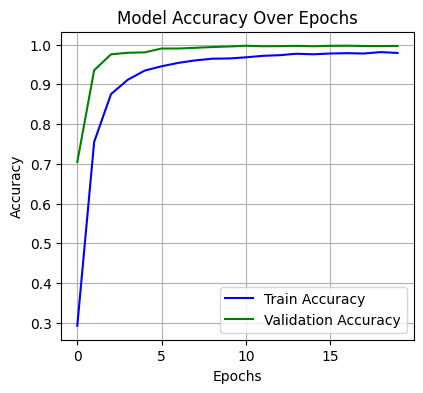

In [19]:
# Plot accuracy/loss with titles and axis labels
plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

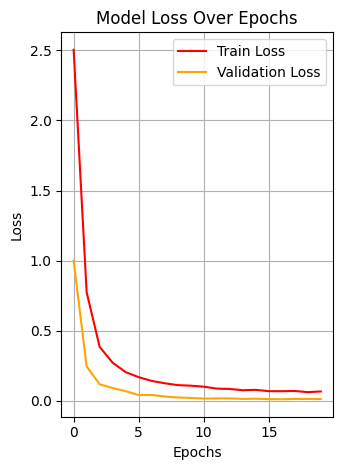

In [20]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Load test data
X_test = np.load('../TSRS-main/X_test.npy')
y_test = np.load('../TSRS-main/y_test.npy')

# Get true class labels from one-hot encoding
y_true_classes = np.argmax(y_test, axis=1)

# Predict class probabilities using the trained model
y_pred_probs = model.predict(X_test)

# Get predicted class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [22]:
from sklearn.metrics import precision_recall_fscore_support

NUM_CLASSES = 43  # Total number of traffic sign classes in GTSRB

# Calculate precision and recall per class
precision, recall, _, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, labels=np.arange(NUM_CLASSES))

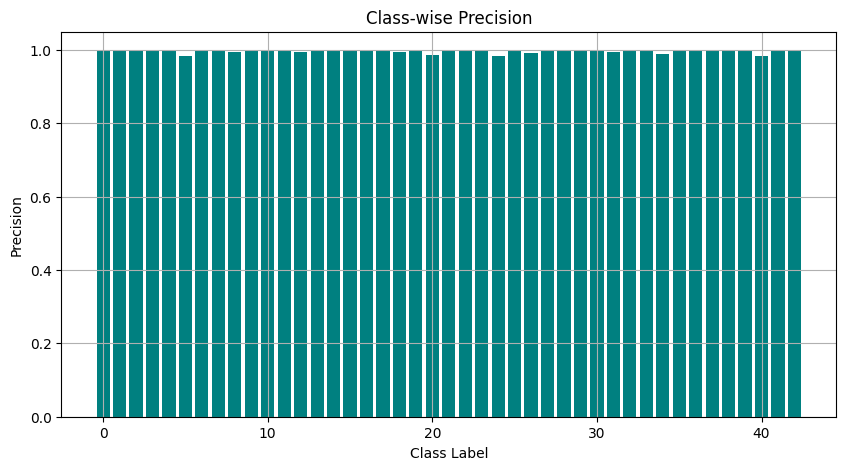

In [23]:
# Plot precision per class
plt.figure(figsize=(10, 5))
plt.bar(np.arange(NUM_CLASSES), precision, color='teal')
plt.title("Class-wise Precision")
plt.xlabel("Class Label")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

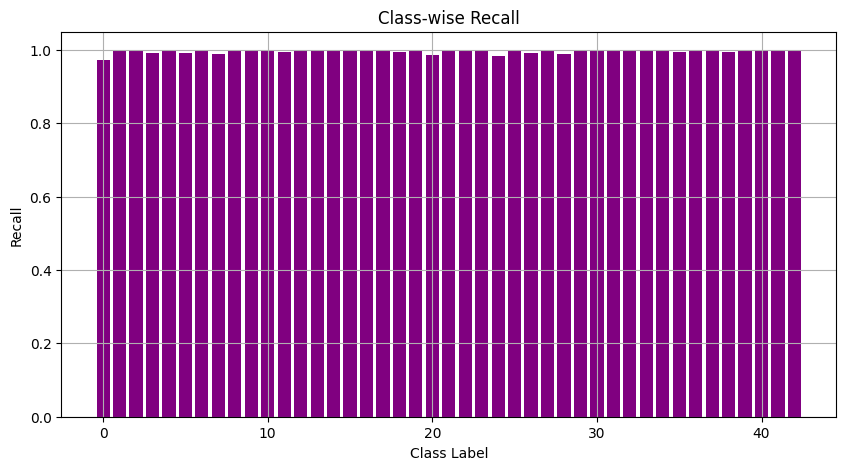

In [24]:
# Plot recall per class
plt.figure(figsize=(10, 5))
plt.bar(np.arange(NUM_CLASSES), recall, color='purple')
plt.title("Class-wise Recall")
plt.xlabel("Class Label")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

# **3. Model Evaluation**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [26]:
# Load the trained model
model = load_model('../TSRS-main/traffic_sign_recognition_system.h5')

# Load preprocessed data
X_train = np.load('../TSRS-main/X_train.npy')
X_test = np.load('../TSRS-main/X_test.npy')
y_train = np.load('../TSRS-main/y_train.npy')
y_test = np.load('../TSRS-main/y_test.npy')

In [27]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [28]:
# Predict on training data
y_pred_train = model.predict(X_train)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_true_train_classes = np.argmax(y_train, axis=1)

981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [29]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9965 - loss: 0.0117
Test Accuracy: 99.72%
Test Loss: 0.0111


In [30]:
# Evaluate the model on train data
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9994 - loss: 0.0041
Train Accuracy: 99.94%
Train Loss: 0.0042


In [31]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      1.00      1.00       496
           2       1.00      1.00      1.00       450
           3       1.00      0.99      1.00       280
           4       1.00      1.00      1.00       418
           5       0.98      0.99      0.99       364
           6       1.00      1.00      1.00        59
           7       1.00      0.99      0.99       278
           8       0.99      1.00      1.00       301
           9       1.00      1.00      1.00       268
          10       1.00      1.00      1.00       370
          11       1.00      1.00      1.00       236
          12       0.99      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       162
          15       1.00      1.00      1.00       120
          16       1.00      1.00      1.00        90
   

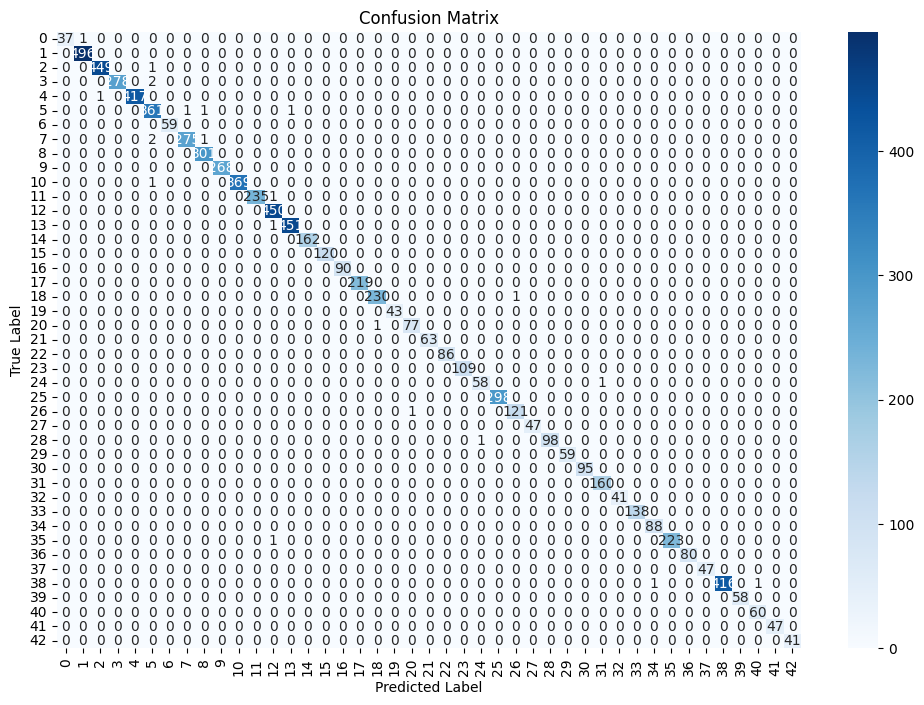

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(43), yticklabels=range(43))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **4. Image Prediction**

In [33]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [34]:
# Load the saved model
model = load_model('../TSRS-main/traffic_sign_recognition_system.h5')

# Load preprocessed data
X_train = np.load('../TSRS-main/X_train.npy')
X_test = np.load('../TSRS-main/X_test.npy')
y_train = np.load('../TSRS-main/y_train.npy')
y_test = np.load('../TSRS-main/y_test.npy')

In [35]:
# Define the traffic sign classes
import pandas as pd
df = pd.read_excel("E:/NIET/traffic_sign_recognition/data/GTSRB/traffic_sign.xlsx")
df = df.sort_values('Class_id')
class_names = df['Name'].tolist()

In [36]:
# Define image size and dataset path
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [37]:
# Function to load and predict on a new image
def test_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image was loaded properly
    if image is None:
        print("Error: Image not found.")
        return

    # Resize image to match model's expected input size
    image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # Normalize pixel values to [0, 1]
    image_resized = image_resized / 255.0

    # Reshape image to match the input shape (batch size, height, width, channels)
    image_reshaped = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_reshaped = np.expand_dims(image_reshaped, axis=-1)  # Add channel dimension for grayscale (if needed)

    # Predict using the model
    prediction = model.predict(image_reshaped)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the name of the sign from the class index
    predicted_sign_name = class_names[predicted_class]

    # Display the image and prediction
    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_sign_name}")
    plt.axis('off')  # Turn off axis
    plt.show()

    return predicted_sign_name


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


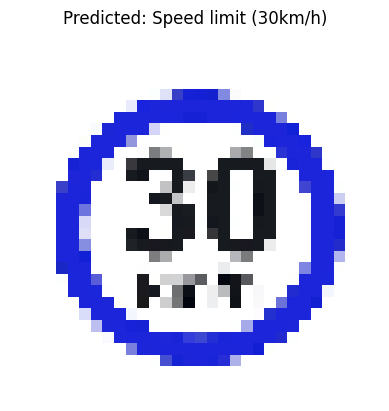

Predicted Sign: Speed limit (30km/h)


In [ ]:
# Test the function with a new image (provide your image path here)
image_path = "E:/NIET/traffic_sign_recognition/testIMG/img2.png"
predicted_sign_name = test_image(image_path)
print(f"Predicted Sign: {predicted_sign_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


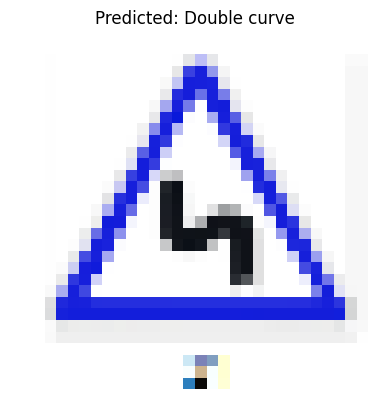

Predicted Sign: Double curve


In [ ]:
# Test the function with a new image (provide your image path here)
image_path = "E:/NIET/traffic_sign_recognition/testIMG/img21.png"
predicted_sign_name = test_image(image_path)
print(f"Predicted Sign: {predicted_sign_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


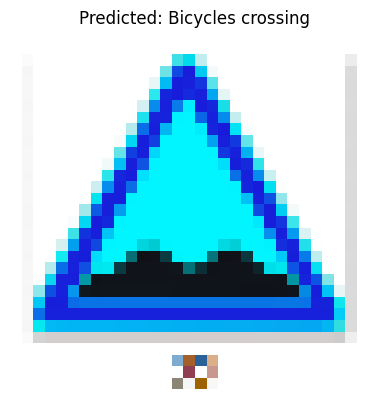

Predicted Sign: Bicycles crossing


In [ ]:
# Test the function with a new image (provide your image path here)
image_path = "E:/NIET/traffic_sign_recognition/testIMG/img22.png"
predicted_sign_name = test_image(image_path)
print(f"Predicted Sign: {predicted_sign_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


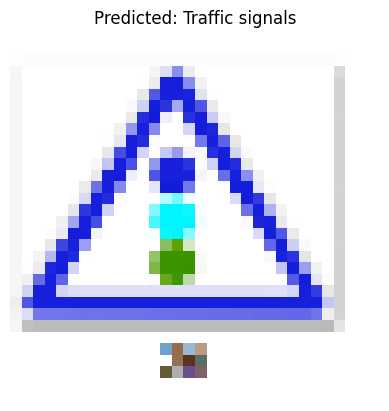

Predicted Sign: Traffic signals


In [ ]:
# Test the function with a new image (provide your image path here)
image_path = "E:/NIET/traffic_sign_recognition/testIMG/img26.png"
predicted_sign_name = test_image(image_path)
print(f"Predicted Sign: {predicted_sign_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


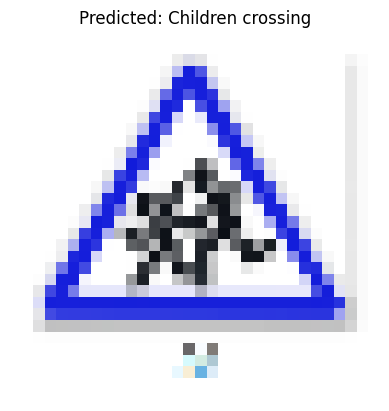

Predicted Sign: Children crossing


In [ ]:
# Test the function with a new image (provide your image path here)
image_path = "E:/NIET/traffic_sign_recognition/testIMG/img28.png"
predicted_sign_name = test_image(image_path)
print(f"Predicted Sign: {predicted_sign_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


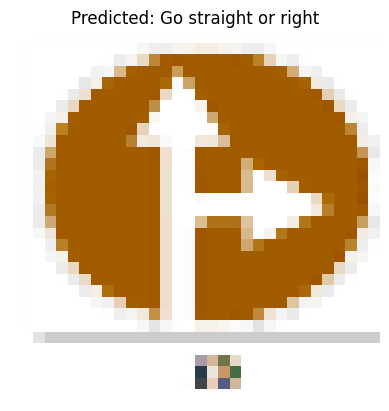

Predicted Sign: Go straight or right


In [ ]:
# Test the function with a new image (provide your image path here)
image_path = "E:/NIET/traffic_sign_recognition/testIMG/img36.png"
predicted_sign_name = test_image(image_path)
print(f"Predicted Sign: {predicted_sign_name}")

# **5. Real Time Detection**

In [44]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [45]:
# Load the trained model
model = load_model('../TSRS-main/traffic_sign_recognition_system.h5')

# Load preprocessed data
X_train = np.load('../TSRS-main/X_train.npy')
X_test = np.load('../TSRS-main/X_test.npy')
y_train = np.load('../TSRS-main/y_train.npy')
y_test = np.load('../TSRS-main/y_test.npy')


In [46]:
# Define constants
IMG_HEIGHT = 30
IMG_WIDTH = 30
NUM_CLASSES = 43


In [47]:
# Define the traffic sign classes
# You can replace this with actual class names if you have them
# CLASS_NAMES = [str(i) for i in range(NUM_CLASSES)]
# GTSRB class labels
import pandas as pd
df = pd.read_excel("E:/NIET/traffic_sign_recognition/data/GTSRB/traffic_sign.xlsx")
df = df.sort_values('Class_id')
CLASS_NAMES = df['Name'].tolist()

In [48]:
# Initialize webcam
cap = cv2.VideoCapture(0)
print("📷 Starting webcam. Press 'q' to exit...")

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to grab frame.")
        break

    # Define region of interest (ROI) in the center of the frame
    roi_size = 100
    center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
    roi = frame[center_y - roi_size:center_y + roi_size, center_x - roi_size:center_x + roi_size]

    # Preprocess ROI
    roi_resized = cv2.resize(roi, (IMG_WIDTH, IMG_HEIGHT))
    roi_normalized = roi_resized / 255.0
    roi_reshaped = np.expand_dims(roi_normalized, axis=0)

    # Predict
    predictions = model.predict(roi_reshaped)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = CLASS_NAMES[predicted_class]
    confidence = np.max(predictions)

    # Draw ROI on the frame
    cv2.rectangle(frame,
                  (center_x - roi_size, center_y - roi_size),
                  (center_x + roi_size, center_y + roi_size),
                  (255, 0, 0), 2)

    # Display class name and confidence
    label = f"{class_name} ({confidence * 100:.1f}%)"
    cv2.putText(frame, label, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow("Traffic Sign Detection - Press Q to quit", frame)

    # Break loop on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
print("✅ Webcam closed.")

📷 Starting webcam. Press 'q' to exit...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━